In [ ]:
#@title 0. Overview & Objectives-Task 1, 2, 3 & 4
"""
TASK 3.2 Practical Assessment – Image Captioning System

Goal:
Build an end-to-end image captioning system that generates meaningful natural-language captions from input images using an encoder–decoder architecture with fusion.

Objectives:
1. Extract semantic features from images using a pretrained ResNet50 (Task 1).
2. Train an LSTM-based caption decoder to generate captions word-by-word (Task 2).
3. Fuse image features with language embeddings using concatenation (Task 3).
4. Train, validate, and evaluate the system with loss/accuracy metrics and BLEU scores (Task 4).

Key Features:
✓ Uses pretrained CNN (pretrained ResNet50) for vision  
✓ Builds a vocabulary with frequency thresholding  
✓ Applies sequence modeling with attention to padding  
✓ Implements early stopping and LR scheduling  
✓ Provides both quantitative (BLEU) and qualitative (image+caption) results

Notebook Structure:
  1. Hyperparameters, Imports & Paths
  2. Image Encoder (ResNet50)
  3. Image Preprocessing (transform + load helper)
  4. Preview: Raw Images (Grid)
  5. Preview: Transformed Inputs
  6. Caption Decoder (LSTM) 
  7. Fusion Logic (in decoder.forward via torch.cat)
  8. Decoder Test with Dummy Caption (I removed it cause it's not needed anymore)
  9. Vocabulary Building & Tokenization
 10. Dataset Splits and DataLoader Setup
 11. Training & Validation Loop (Early Stopping)
 12. Training vs. Validation Curves
 13. Inference – Generate Caption for One Image
 14. Evaluation: BLEU-1 to BLEU-4 on Test Set
 15. Visualization: Ground Truth vs Generated Captions
"""


'\nTASK 3.2 Practical Assessment – Image Captioning System\n\nGoal:\nBuild an end-to-end image captioning system that generates meaningful natural-language captions from input images using an encoder–decoder architecture with fusion.\n\nObjectives:\n1. Extract semantic features from images using a pretrained ResNet50 (Task 1).\n2. Train an LSTM-based caption decoder to generate captions word-by-word (Task 2).\n3. Fuse image features with language embeddings using concatenation (Task 3).\n4. Train, validate, and evaluate the system with loss/accuracy metrics and BLEU scores (Task 4).\n\nKey Features:\n✓ Uses pretrained CNN (pretrained ResNet50) for vision  \n✓ Builds a vocabulary with frequency thresholding  \n✓ Applies sequence modeling with attention to padding  \n✓ Implements early stopping and LR scheduling  \n✓ Provides both quantitative (BLEU) and qualitative (image+caption) results\n\nNotebook Structure:\n  1. Hyperparameters, Imports & Paths\n  2. Image Encoder (ResNet50)\n  3. 

In [67]:
#@title  Task Summary – Lab 3: Practical Assessment
"""
This notebook implements **Tasks 1–4** from the Image Captioning Lab for **Task 3.2 Practical Assessment**.

────────────────────────────────────────────────────────
🔹 Task 1: Image Feature Extraction
────────────────────────────────────────────────────────
• We use a pretrained **ResNet-50** model to extract visual features from images.  
• The original classification layer is removed and replaced with a new **fully connected layer** to reduce the output to a **256-dimensional vector**.  
• This vector captures the important content of the image and is passed into the caption model.

────────────────────────────────────────────────────────
🔹 Task 2: Language (Caption) Model
────────────────────────────────────────────────────────
• We build a **caption generator** using an **LSTM network**.  
• It takes a sequence of words (the caption) and learns to predict the next word based on the previous ones.  
• During testing, it starts from the image features and generates a caption one word at a time.

────────────────────────────────────────────────────────
🔹 Task 3: Fusion of Visual and Text Embeddings
────────────────────────────────────────────────────────
• To connect the image and text models, we **combine the image vector with each word vector** using concatenation.  
• This combined input is sent into the LSTM so that every word prediction is influenced by both the image and previous words.  
• This fusion step is done directly inside the decoder using `torch.cat`.

────────────────────────────────────────────────────────
🔹 Task 4: Training and Validation
────────────────────────────────────────────────────────
• The model is trained using **cross-entropy loss**, and we measure how often it predicts the correct word (**token accuracy**).  
• We use a training method called **teacher forcing**, which helps the model learn faster by feeding in the correct previous word.  
• If captions in a batch have different lengths, we automatically **pad shorter ones** so they can be processed together.  
• Training stops early if validation performance doesn't improve for several epochs (**early stopping**).  
• The dataset is split into **70% for training**, **15% for validation**, and **15% for testing**.

────────────────────────────────────────────────────────
 Evaluation & Testing
────────────────────────────────────────────────────────
• The final model is tested using **BLEU scores** (1–4), which compare the generated captions to real ones.  
• We display **six test images** along with the model’s generated captions and the actual (ground truth) captions.  
• A plot of **training and validation loss and accuracy** over time shows how well the model learned.  
• The best model (with the lowest validation loss) is restored and used for evaluation.

"""



"\nThis notebook implements **Tasks 1–4** from the Image Captioning Lab for **Task 3.2 Practical Assessment**.\n\n────────────────────────────────────────────────────────\n🔹 Task 1: Image Feature Extraction\n────────────────────────────────────────────────────────\n• We use a pretrained **ResNet-50** model to extract visual features from images.  \n• The original classification layer is removed and replaced with a new **fully connected layer** to reduce the output to a **256-dimensional vector**.  \n• This vector captures the important content of the image and is passed into the caption model.\n\n────────────────────────────────────────────────────────\n🔹 Task 2: Language (Caption) Model\n────────────────────────────────────────────────────────\n• We build a **caption generator** using an **LSTM network**.  \n• It takes a sequence of words (the caption) and learns to predict the next word based on the previous ones.  \n• During testing, it starts from the image features and generates a

In [68]:
#@title 1. Hyperparameters, Imports & Paths 


# These control the overall training behavior and model size

batch_size      = 32     # Number of images per batch during training
num_epochs      = 30     # Max number of training loops (early stopping may halt earlier)
embed_size      = 256    # Size of both image and word embeddings (after projection)
hidden_size     = 512    # Number of units in LSTM hidden layers
num_layers      = 1      # Number of stacked LSTM layers
freq_threshold  = 2      # Only words with ≥5 occurrences are added to the vocabulary
learning_rate   = 1e-3   # Starting learning rate for Adam optimizer
step_lr_step    = 5      # How many epochs before reducing the learning rate
step_lr_gamma   = 0.8    # How much to multiply learning rate by every `step_lr_step` epochs
early_patience  = 5      # Stop training if validation loss doesn't improve after 3 epochs
max_caption_len = 30     # Max number of words in a generated caption
dropout         = 0.3    # Dropout rate in the decoder LSTM (if num_layers > 1)


# — IMPORTS —
# Required libraries for building, training, and evaluating the model

import os, re, random                             # file handling, regex, and reproducibility
import torch                                      # main deep learning framework
import matplotlib.pyplot as plt                   # for loss/accuracy curve and image plots
import torch.nn as nn, torch.optim as optim       # neural network layers and optimizers
from torch.utils.data import Dataset, DataLoader  # custom datasets and batching
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence  # handling variable-length captions
import torchvision.transforms as T, torchvision.models as models   # image preprocessing & pretrained CNN
from PIL import Image                             # for loading .jpg images
from collections import defaultdict, Counter      # for organizing captions and counting word frequency
from nltk.translate.bleu_score import sentence_bleu  # BLEU score metric for evaluation
from tqdm import tqdm                             # progress bars during training
import nltk; nltk.download('punkt')               # download tokenizer for BLEU scoring

# — PATHS (CHANGE AS NEEDED) —
# Path to local dataset (images and captions)

img_dir  = r"C:\Users\Deborah Aittokallio\D7047E_exercise_group_5\Lab3\Images"        # Folder of images
cap_file = r"C:\Users\Deborah Aittokallio\D7047E_exercise_group_5\Lab3\captions.txt"  # File of image-caption pairs

# — DEVICE —
# Automatically use GPU if available, otherwise fall back to CPU

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)  # Shows "cuda" if a GPU is being used


cuda


[nltk_data] Downloading package punkt to C:\Users\Deborah
[nltk_data]     Aittokallio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


TASK 1 – Image Feature Extraction

In [69]:
#@title 2. Define Image Encoder (CNN)

class EncoderCNN(nn.Module):
    """
    This class extracts a fixed-size vector from an input image.
    
    Architecture:
    - Uses a pretrained ResNet-50 to extract high-level features.
    - Removes the classification head (we don’t need ImageNet labels).
    - Applies adaptive pooling to reduce spatial dimensions to 1x1.
    - Adds a trainable fully connected (fc) layer to project to embed_size (256).
    
    Training:
    - All layers of ResNet are frozen (not updated during training).
    - Only the final FC layer is trainable.
    
    Output:
    - A 256-dimensional feature vector for each input image.
    """

    def __init__(self, embed_size):
        super().__init__()

        # Load ResNet-50 with pretrained weights
        resnet = models.resnet50(weights="DEFAULT")

        # Remove the last two layers (avgpool and fully connected classification layer)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])  # Output: (B, 2048, H/32, W/32)

        # Adaptive pooling to convert feature maps to shape (B, 2048, 1, 1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Final trainable layer: maps 2048-D to embed_size (256-D)
        self.fc = nn.Linear(2048, embed_size)

        # Freeze all layers in the CNN (only train the final FC layer)
        for p in self.cnn.parameters():
            p.requires_grad = False

    def forward(self, imgs):
        """
        Forward pass through the encoder.

        Args:
            imgs (Tensor): Batch of preprocessed images (B, 3, 256, 256)

        Returns:
            Tensor: Image embeddings of shape (B, embed_size)
        """

        # Pass image through the CNN backbone
        x = self.cnn(imgs)  # Output: (B, 2048, H/32, W/32)

        # Reduce spatial dimensions to (1, 1) and remove unnecessary dims
        x = self.pool(x).squeeze()  # Output: (B, 2048)

        # Project to embedding space (256-D)
        return self.fc(x)  # Output: (B, embed_size)


In [70]:
#@title 3. Image Preprocessing Function

# Define preprocessing steps to apply to each input image
transform = T.Compose([
    T.Resize((256, 256)),  # Resize image to a fixed size (expected by CNN)
    T.ToTensor(),          # Convert PIL Image to a PyTorch tensor (shape: [C, H, W], values in [0,1])
    T.Normalize(           # Normalize pixel values using ImageNet mean and std
        mean=(0.485, 0.456, 0.406),  # Average RGB values from ImageNet dataset
        std=(0.229, 0.224, 0.225)    # Standard deviations for RGB channels
    )
])

def load_image(path):
    """
    Loads a single image from file and applies the transform.

    Args:
        path (str): Full path to the image file (e.g., .jpg)

    Returns:
        Tensor: Preprocessed image tensor of shape (1, 3, 256, 256)
                - The extra batch dimension (1) is added for model input
    """
    # Open image and convert to RGB format (in case it's grayscale or CMYK)
    img = Image.open(path).convert("RGB")

    # Apply the defined transform and add a batch dimension
    return transform(img).unsqueeze(0)  # Output shape: (1, 3, 256, 256)


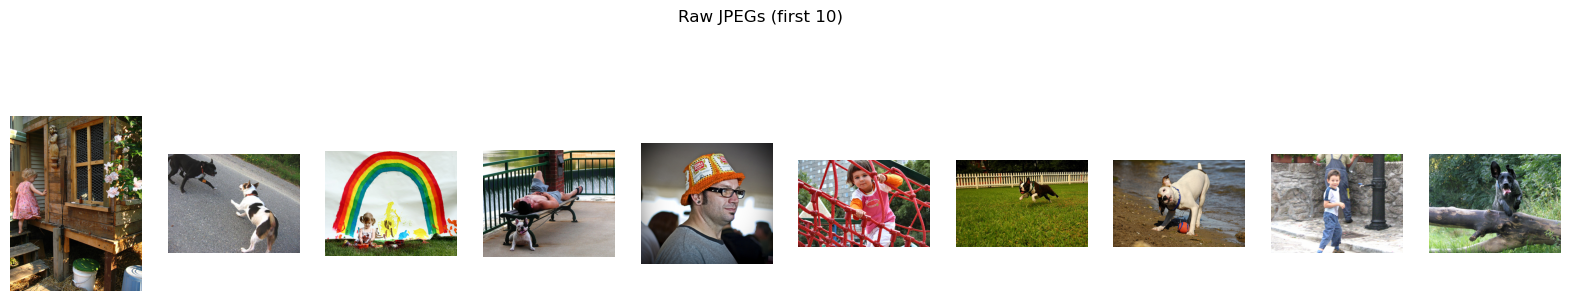

In [71]:
#@title 4. Show 10 Original Images (Preview as Grid)

# This block displays the first 10 images from the dataset in a horizontal grid.
# It's useful to quickly verify that the dataset was loaded correctly
# and that the images are visually reasonable before training.

import matplotlib.pyplot as plt, itertools  # plt is already imported earlier; itertools not used here

# Get the first 10 image filenames (sorted alphabetically)
sample_imgs = sorted(os.listdir(img_dir))[:10]

# Set up a horizontal figure for plotting
plt.figure(figsize=(20, 4))  # width=20, height=4 inches

# Loop through each image and plot it
for i, f in enumerate(sample_imgs):
    plt.subplot(1, 10, i + 1)  # 1 row, 10 columns, position i+1
    plt.imshow(Image.open(os.path.join(img_dir, f)))  # Load and display the image
    plt.axis("off")  # Hide axis ticks and borders

# Add a title above the full grid
plt.suptitle("Raw JPEGs (first 10)")  
plt.show()  # Display the entire plot


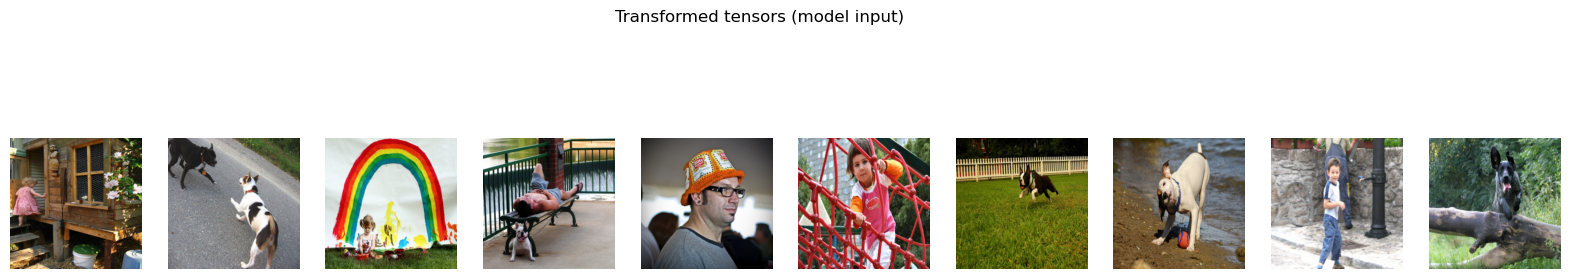

In [72]:
#@title 5. Show 10 Transformed Images (Post-Processing)

# This block shows the same 10 images as before,
# but *after* they have been passed through the transform pipeline.
# It helps verify that resizing, normalization, and tensor conversion work as expected.

plt.figure(figsize=(20, 4))  # Set up a wide figure for displaying 10 images

for i, f in enumerate(sample_imgs):
    # Load and preprocess the image
    tens = transform(Image.open(os.path.join(img_dir, f)).convert("RGB"))

    # Clone the tensor so we can un-normalize it for display (visualization only)
    vis = tens.clone()

    # ImageNet normalization reversal: (x * std + mean)
    # These are reshaped to [3, 1, 1] to apply per-channel across height & width
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # Un-normalize and clamp to [0, 1] for valid image display
    vis = (vis * std + mean).clamp(0, 1)

    # Convert to shape (H, W, 3) and numpy format for plt.imshow
    vis = vis.permute(1, 2, 0).numpy()

    # Display the transformed image in a subplot
    plt.subplot(1, 10, i + 1)
    plt.imshow(vis)
    plt.axis("off")

# Add a title for the whole grid
plt.suptitle("Transformed tensors (model input)")
plt.show()


TASK 2 – Language (Caption) Model

In [73]:
#@title 6. Define Caption Decoder (LSTM)

class DecoderRNN(nn.Module):
    """
    Caption Decoder using an LSTM (Long Short-Term Memory network).
    
    Purpose:
    - Given an image feature vector and a sequence of input words (caption),
      this decoder learns to predict the next word at each time step.

    Fusion (Task 3):
    - Fusion is done by concatenating the image feature vector with each word embedding.
    - This combined input is passed to the LSTM at every step.
    """

    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()

        # Embedding layer maps word indices to dense vectors of size `embed_size`
        self.embed = nn.Embedding(vocab_size, embed_size)

        # LSTM takes in concatenated [image_embedding | word_embedding]
        # So input size = embed_size * 2 (because of fusion)
        self.lstm  = nn.LSTM(input_size=embed_size * 2,
                             hidden_size=hidden_size,
                             dropout=dropout if num_layers > 1 else 0.0,  # dropout only works if num_layers > 1
                             batch_first=True)

        # Fully connected output layer: maps LSTM hidden state to vocabulary logits
        self.fc    = nn.Linear(hidden_size, vocab_size)

    def forward(self, feats, caps, lengths):
        """
        Forward pass for training the decoder.

        Args:
            feats   (Tensor): Image features of shape (B, embed_size)
            caps    (Tensor): Caption word indices (B, L)
            lengths (Tensor): Actual lengths of captions (before padding)

        Returns:
            Tensor: Output logits of shape (total_words, vocab_size)
        """

        # 1. Get word embeddings for input captions → (B, L, E)
        emb = self.embed(caps)  # E = embed_size

        # 2. ─── Fusion happens here ───
        # Repeat the image features across the caption sequence length
        # (B, embed_size) → (B, L, embed_size)
        feats = feats.unsqueeze(1).repeat(1, emb.size(1), 1)

        # Concatenate image features and word embeddings at each time step
        # Result: (B, L, 2 * embed_size)
        x = torch.cat([feats, emb], dim=2)

        # 3. Pack sequences so LSTM ignores padding tokens during training
        packed = pack_padded_sequence(x, lengths.cpu(),
                                      batch_first=True,
                                      enforce_sorted=False)

        # 4. Pass through LSTM
        h, _ = self.lstm(packed)

        # 5. Predict vocabulary distribution for each word
        return self.fc(h.data)  # Output: (total_words, vocab_size)


TASK 3 – Data Prep & Fusion Setup

In [ ]:
#@title 9. Build Vocabulary & Tokenize Captions 

# This block performs two main tasks:
# 1. Parses the caption file into a dictionary: {image → [list of captions]}
# 2. Builds a vocabulary from the captions, keeping only frequent words

# -----------------------------------------------------------
# PART 1: Read the captions.txt and parse each image–caption pair
# -----------------------------------------------------------

captions_raw = defaultdict(list)  # Dictionary: image filename → list of captions

with open(cap_file, encoding="utf8") as f:
    for line in (l.strip() for l in f):
        if not line: continue  # skip empty lines

        pos = line.lower().find(".jpg")  # find the filename ending
        if pos == -1: continue  # skip malformed lines

        img = line[:pos+4]  # extract image filename
        cap = line[pos+4:].lstrip(" \t,#0123456789")  # strip separators before the caption text

        captions_raw[img].append(cap)  # store caption for that image

# -----------------------------------------------------------
# PART 2: Define the Vocabulary class
# -----------------------------------------------------------

class Vocabulary:
    def __init__(self, freq_th):
        self.freq_th = freq_th

        # Predefined special tokens and their indices
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.stoi = {v: k for k, v in self.itos.items()}

    def __len__(self):
        return len(self.itos)  # number of unique tokens in vocabulary

    def _tok(self, s):
        """
        Tokenizer: lowercase, remove non-alphanumerics, split on spaces.
        Example: "A cat's tail!" → ["a", "cat", "s", "tail"]
        """
        return re.sub(r"[^a-z0-9]+", " ", s.lower()).split()

    def build(self, sents):
        """
        Build the vocabulary using a list of all caption sentences.
        Only include words that appear at least `freq_threshold` times.
        """
        freq = Counter()  # count word frequencies
        idx = 4  # start indexing after the special tokens

        for s in sents:
            for t in self._tok(s):
                freq[t] += 1
                if freq[t] == self.freq_th:
                    # Add to vocab once threshold is reached
                    self.stoi[t] = idx
                    self.itos[idx] = t
                    idx += 1

    def numericalize(self, s):
        """
        Convert a sentence (string) to a list of word indices.
        Unknown words get mapped to <unk> (index 3).
        """
        return [self.stoi.get(t, 3) for t in self._tok(s)]

    # Alias for backward compatibility
    nums = numericalize

# -----------------------------------------------------------
# PART 3: Build the vocabulary from all the captions
# -----------------------------------------------------------

vocab = Vocabulary(freq_threshold)

# Flatten the list of caption lists into a single list of all captions
all_caps = [c for caps in captions_raw.values() for c in caps]

# Build the vocab using all available captions
vocab.build(all_caps)

# -----------------------------------------------------------
# PART 4: Print stats and show an example
# -----------------------------------------------------------

print("\n✔ Parsed images :", len(captions_raw))     # Number of images
print("✔ Captions count:", len(all_caps))           # Total number of captions
print("✔ Vocab size    :", len(vocab))              # Total number of unique tokens in vocab

# Show a random example image and 2 of its captions
sample_key = next(iter(captions_raw))
print("\nSample image key :", sample_key)
print("Sample captions  :", captions_raw[sample_key][:2])



✔ Parsed images : 8091
✔ Captions count: 40455
✔ Vocab size    : 2982

Sample image key : 1000268201_693b08cb0e.jpg
Sample captions  : ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .']


In [ ]:
#@title 10. Dataset & DataLoaders (train / val / test)

# -----------------------------------------------------------
# PART 1: Split image-caption data into train / val / test
# -----------------------------------------------------------

# Get a list of all image filenames
keys = list(captions_raw.keys())

# Shuffle the keys to randomize the dataset (reproducible with seed 42)
random.Random(42).shuffle(keys)

N = len(keys)  # total number of images

# 70% → train, 15% → val, 15% → test
train_keys = keys[:int(0.70 * N)]
val_keys   = keys[int(0.70 * N):int(0.85 * N)]
test_keys  = keys[int(0.85 * N):]

# -----------------------------------------------------------
# PART 2: Custom Dataset class for Flickr8k-style data
# -----------------------------------------------------------

class FlickrDataset(Dataset):
    """
    A PyTorch Dataset that:
    - Loads an image from disk and applies transforms
    - Retrieves the first caption for that image
    - Converts the caption to a sequence of token IDs
    """
    def __init__(self, key_list):
        self.keys = key_list  # list of image filenames

    def __len__(self):
        return len(self.keys)  # number of items in the dataset

    def __getitem__(self, i):
        fname = self.keys[i]  # get filename

        # Load and preprocess the image
        img = transform(Image.open(os.path.join(img_dir, fname)).convert("RGB"))

        # Use the first caption for this image
        cap = captions_raw[fname][0]

        # Convert caption to token IDs, adding <start> and <end> tokens
        ids = [1] + vocab.numericalize(cap) + [2]

        return img, torch.tensor(ids)  # image tensor, caption tensor

# -----------------------------------------------------------
# PART 3: Collate function for DataLoader (batch padding)
# -----------------------------------------------------------

def collate(batch):
    """
    Custom collate function that:
    - Stacks images into a batch tensor (B, 3, 256, 256)
    - Pads captions to match the longest in the batch
    - Computes the original lengths of each caption
    """
    imgs, caps = zip(*batch)  # unzip list of tuples into two lists
    imgs = torch.stack(imgs)  # stack image tensors into a batch
    lens = torch.tensor([len(c) for c in caps])  # get original lengths
    caps = pad_sequence(caps, batch_first=True, padding_value=0)  # pad captions
    return imgs, caps, lens

# -----------------------------------------------------------
# PART 4: Create DataLoaders for each split
# -----------------------------------------------------------

# Train loader → shuffles the dataset
train_loader = DataLoader(
    FlickrDataset(train_keys),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate
)

# Validation loader → no shuffling
val_loader = DataLoader(
    FlickrDataset(val_keys),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate
)

# Test loader → no shuffling
test_loader = DataLoader(
    FlickrDataset(test_keys),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate
)

# Print summary of loaders
print("Loaders: train", len(train_loader),
      "| val", len(val_loader),
      "| test", len(test_loader))


Loaders: train 177 | val 38 | test 38


TASK 4 – Train, Validate, Curves, Eval

In [ ]:
#@title 11. Train & Validate w/ Early Stopping 

# Instantiate model components and move them to the chosen device (GPU or CPU)
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab)).to(device)

# Loss function: ignore <pad> tokens (index 0) during training
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Optimizer: updates decoder parameters and final FC layer of the encoder
optimizer = optim.Adam(
    list(decoder.parameters()) + list(encoder.fc.parameters()),
    lr=learning_rate
)

# Learning rate scheduler: reduce LR after `step_lr_step` epochs by `step_lr_gamma`
scheduler = optim.lr_scheduler.StepLR(optimizer, step_lr_step, gamma=step_lr_gamma)

# Accuracy helper: compute % of non-padding tokens predicted correctly
def token_acc(logits, targets):
    mask = targets != 0  # mask out <pad> positions
    preds = logits.argmax(1)  # predicted token IDs
    return ((preds == targets) & mask).sum() / mask.sum()

# Track the best validation loss for early stopping
best_val = float("inf")
no_imp = 0  # counter for no improvement

# Store loss and accuracy for plotting later
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Start training loop
for epoch in range(1, num_epochs + 1):

    # ============================
    #        TRAINING PHASE
    # ============================
    encoder.train()
    decoder.train()
    tloss = tcorrect = ttok = 0  # total loss, correct tokens, total tokens

    for imgs, caps, lens in tqdm(train_loader, leave=False):
        imgs, caps = imgs.to(device), caps.to(device)

        optimizer.zero_grad()

        # Forward pass
        feats = encoder(imgs)  # (B, 256)
        logits = decoder(feats, caps[:, :-1], lens - 1)  # input everything except <end>

        # Targets: actual next words (everything except <start>)
        targets = pack_padded_sequence(
            caps[:, 1:], lens - 1, batch_first=True, enforce_sorted=False
        ).data

        # Compute loss and backpropagate
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        # Update metrics
        tloss += loss.item() * targets.size(0)
        tcorrect += token_acc(logits, targets) * targets.size(0)
        ttok += targets.size(0)

    # Store average loss/accuracy for training epoch
    train_losses.append(tloss / ttok)
    train_accs.append((tcorrect / ttok).item())
    scheduler.step()

    # ============================
    #      VALIDATION PHASE
    # ============================
    encoder.eval()
    decoder.eval()
    vloss = vcorrect = vtok = 0

    with torch.no_grad():
        for imgs, caps, lens in val_loader:
            imgs, caps = imgs.to(device), caps.to(device)
            logits = decoder(encoder(imgs), caps[:, :-1], lens - 1)
            targets = pack_padded_sequence(
                caps[:, 1:], lens - 1, batch_first=True, enforce_sorted=False
            ).data

            vloss += criterion(logits, targets).item() * targets.size(0)
            vcorrect += token_acc(logits, targets) * targets.size(0)
            vtok += targets.size(0)

    # Store average loss/accuracy for validation epoch
    val_losses.append(vloss / vtok)
    val_accs.append((vcorrect / vtok).item())

    # ============================
    #       LOGGING & EARLY STOP
    # ============================
    print(
        f"Epoch {epoch:02} | "
        f"Train {train_losses[-1]:.4f}, {train_accs[-1]:.2%} || "
        f"Val {val_losses[-1]:.4f}, {val_accs[-1]:.2%}",
        end=""
    )

    # Save model if validation loss improved
    if val_losses[-1] < best_val:
        best_val = val_losses[-1]
        best_state = (encoder.state_dict(), decoder.state_dict())
        # Save corresponding training/validation accuracy at this epoch
        best_train_acc = train_accs[-1]
        best_val_acc = val_accs[-1]

        no_imp = 0
        print(" ✅")  # indicates improvement

    else:
        no_imp += 1
        print(f" ⚠ {no_imp}/{early_patience}")
        if no_imp >= early_patience:
            print("Early stop")
            break

# ============================
#       FINALIZE BEST MODEL
# ============================

# Restore the best model weights from early stopping
# Load best model and report best scores
encoder.load_state_dict(best_state[0])
decoder.load_state_dict(best_state[1])

print(f"\n✅ Best val loss  : {best_val:.4f}")
print(f"✅ Best train acc : {best_train_acc:.2%}")
print(f"✅ Best val acc   : {best_val_acc:.2%}")


Epoch 01 | Train 4.4111, 27.90% || Val 3.7574, 33.84% ✅


Epoch 02 | Train 3.4483, 36.19% || Val 3.3890, 37.40% ✅


Epoch 03 | Train 3.0453, 39.92% || Val 3.2038, 39.12% ✅


Epoch 04 | Train 2.7563, 42.57% || Val 3.1194, 40.01% ✅


Epoch 05 | Train 2.5097, 44.97% || Val 3.0790, 40.51% ✅


Epoch 06 | Train 2.2545, 48.18% || Val 3.0567, 40.91% ✅


Epoch 07 | Train 2.0656, 50.83% || Val 3.0564, 41.29% ✅


Epoch 08 | Train 1.8872, 53.87% || Val 3.0772, 40.84% ⚠ 1/3


Epoch 09 | Train 1.7102, 57.58% || Val 3.1083, 40.22% ⚠ 2/3


Epoch 10 | Train 1.5414, 61.17% || Val 3.1427, 40.39% ⚠ 3/3
Early stop

✅ Best val loss  : 3.0564
✅ Best train acc : 50.83%
✅ Best val acc   : 41.29%


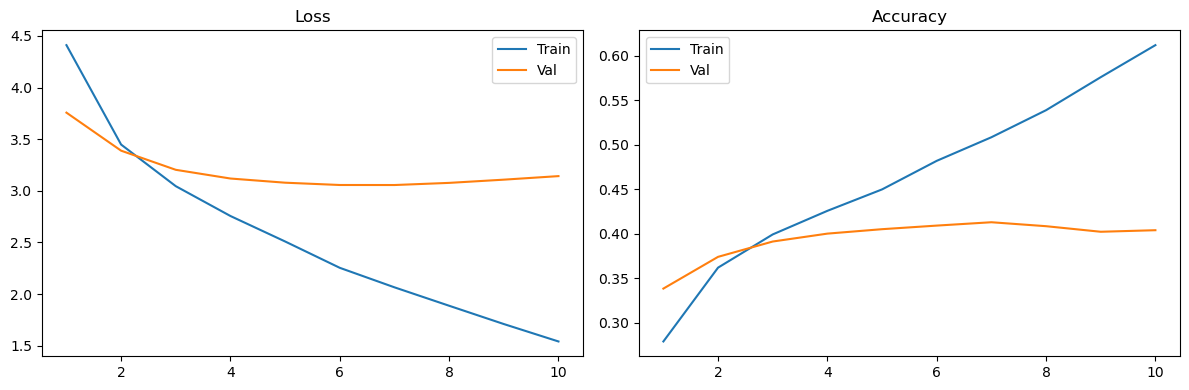

In [ ]:
#@title 12. Training vs. Validation plot 📈
epochs = range(1,len(train_losses)+1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(epochs,train_losses,label="Train")
plt.plot(epochs,val_losses,label="Val"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(epochs,train_accs,label="Train")
plt.plot(epochs,val_accs,label="Val"); plt.title("Accuracy"); plt.legend()
plt.tight_layout(); plt.show()


In [ ]:
#@title 13. Caption Generation (Inference) 🗣️

def generate_caption(path, max_len=max_caption_len):
    """
    Generates a caption for a single image using the trained encoder and decoder.

    Args:
        path (str): Full path to an image file (.jpg)
        max_len (int): Maximum number of words to generate

    Returns:
        str: The generated caption as a string
    """
    
    # Set both models to evaluation mode (disables dropout, etc.)
    encoder.eval()
    decoder.eval()

    # Load and preprocess the input image, add batch dimension
    img = transform(Image.open(path).convert("RGB")).unsqueeze(0).to(device)

    with torch.no_grad():  # disable gradient calculation for inference
        # Extract 256-D feature vector from image
        feat = encoder(img)  # shape: (1, 256)

        # If output is 1D (batch dim collapsed), add it back
        feat = feat.unsqueeze(0) if feat.dim() == 1 else feat  # shape: (1, 256)

        # Start token to begin decoding
        word = torch.tensor([vocab.stoi["<start>"]], device=device)

        # Initial LSTM hidden and cell states
        h, c = None, None

        # List to collect generated words
        out_words = []

        # Generate up to max_len words
        for _ in range(max_len):
            # Embed the current word (shape: (1, 1, embed_size))
            emb = decoder.embed(word).unsqueeze(1)

            # Repeat image features across time dimension (only 1 step here)
            fused = torch.cat([feat.unsqueeze(1), emb], dim=2)  # shape: (1, 1, 2*embed_size)

            # Pass through LSTM (1 time step at a time)
            out, (h, c) = decoder.lstm(fused, (h, c) if h is not None else None)

            # Predict the next word from output (logits → highest prob)
            word = decoder.fc(out.squeeze(1)).argmax(1)  # shape: (1,)

            # If <end> token is reached, stop generation
            if word.item() == vocab.stoi["<end>"]:
                break

            # Append predicted word to output
            out_words.append(vocab.itos[word.item()])

        # Return the full caption as a space-separated string
        return " ".join(out_words) or "(empty)"


# Run a quick test on one random test image
print("Quick test:", generate_caption(os.path.join(img_dir, test_keys[0])))


Quick test: a group of people ride on the road with their backpacks


BLEU-1 0.534  BLEU-2 0.336  BLEU-3 0.176  BLEU-4 0.077


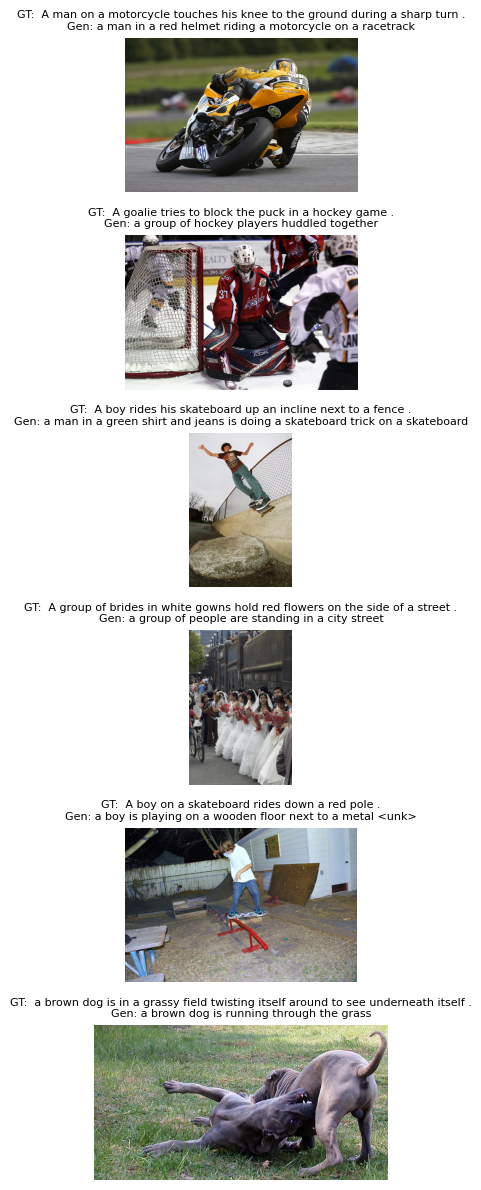

In [ ]:
#@title 14. Evaluation and visualisation of results (Testset)

# -------------------------------
# Part 1: Calculate BLEU scores
# -------------------------------

# Define BLEU weights:
# BLEU-1 = unigram, BLEU-2 = bigram, etc.
weights = [
    (1, 0, 0, 0),               # BLEU-1
    (0.5, 0.5, 0, 0),           # BLEU-2
    (0.33, 0.33, 0.33, 0),      # BLEU-3
    (0.25, 0.25, 0.25, 0.25)    # BLEU-4
]

tot = [0, 0, 0, 0]  # to store total BLEU scores

# Loop over each image in the test set
for k in test_keys:
    # Ground truth references: tokenized versions of all captions for this image
    refs = [vocab._tok(c) for c in captions_raw[k]]

    # Hypothesis (generated caption) from the model
    hyp = generate_caption(os.path.join(img_dir, k)).split()

    # Compute BLEU-1 to BLEU-4 and accumulate totals
    for i, w in enumerate(weights):
        tot[i] += sentence_bleu(refs, hyp, weights=w)

# Average BLEU scores over all test images
bleu = [t / len(test_keys) for t in tot]

# Print the BLEU scores with 3 decimal places
print(f"BLEU-1 {bleu[0]:.3f}  BLEU-2 {bleu[1]:.3f}  BLEU-3 {bleu[2]:.3f}  BLEU-4 {bleu[3]:.3f}")

# -------------------------------
# Part 2: Show visual examples
# -------------------------------

# Show 6 random test images with their:
# - Ground truth (GT) caption
# - Generated caption from model

plt.figure(figsize=(8, 12))  # create tall figure

# Randomly select 6 test images
for i, k in enumerate(random.sample(test_keys, 6)):
    plt.subplot(6, 1, i + 1)  # 6 rows, 1 column
    plt.imshow(Image.open(os.path.join(img_dir, k)))  # show image
    plt.axis("off")

    # Display both GT and generated captions
    plt.title(
        f"GT:  {captions_raw[k][0]}\nGen: {generate_caption(os.path.join(img_dir, k))}",
        fontsize=8
    )

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
